# <u>Machine Learning Lab : Assignment 3</u>

## Genetic Algorithm

Notebook authored by Sonaal P. Pradeep (B170163CS)

<hr>

## About the algorithm

Brute force applications of problems require a lot of time and processing power to find an optimal solution. The genetic algorithm is an approach which incorporates techniques <b>seen naturaly in nature</b>, in the form of evolution.

One iteration in a genetic algorithm consists of the following : 
1. Parent Selection
2. Inter-Breeding
3. Mutation
4. Survivors Selection

Before implementing a problem for this algorithm, the problem <b>needs to be encoded</b>. The encoding can be of the following forms : 
1. Binary Representation
2. Integer Representation
3. Real Value Representation
4. Permutation Representation

<br>

## Constraints given 

1. The <b>objective function</b> used is $f(x) = x^3 + 9$. The goal is to <b> maximize the objective fuction</b>.
2. The value of _x_ is represented as a <b>$6$ digit binary number</b>. 
3. Binary encoding scheme
4. Size of the population is $10$
5. Parent selection is based on the <b>Roulette Wheel selection </b>.
6. Mutation probability $0.01$.
7. Survival selection criteria : Replace $20$% worst population in offsprings with $20$% best population from the parent.

<br>

## Importing necessary modules

In [16]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10

## User defined functions

In [17]:
def f(x):
    '''
    The objective function is defined so that it can be used in the calculations involved in the roulette 
    wheel selection and survivor selection.
    
    Input : Number
    Returns : The value wrt the objective function i.e x^3 + 9
    '''
    return pow(x, 3) + 9

In [18]:
def create_Parents(population_Size, bit_Length):
    '''
    The parents choosen initially are generated randomly based on the constraints / encoding of the problem
    
    Parameters : population_Size - The number of parents to choose
                 bit_Length - Problem specific encoding, acts as encoding
                 
    Returns : bitStrings of required length and size. The string format for binary numbers are removed as well
    and appended to the left with 0's, the corressponding list of numbers
    '''
    max_number = pow(2, bit_Length) - 1
    num_list = [np.random.randint(0, max_number) for _ in range(population_Size)]
    
    return [format(num, "#08b").lstrip('0b').zfill(6) for num in num_list]

In [19]:
def find_chance(parents):
    '''
    Finds the probabilities required for the roulette wheel selection
    
    Input : parents - The parents who's chances need to be calculated
    Returns : List of chances for corresponding parents
    '''
    num_list = [int(b, 2) for b in parents]
    list_sum = sum([f(x) for x in num_list])
    
    return [f(num) / list_sum for num in num_list]

In [20]:
def select_Succesors(parents, population):
    '''
    Choosing the successors which will propogate to the next generation
    
    Input : parents - The parents who have chances to go to the next generation
            population - 
    Returns : The choosen children to go to the next generation
    '''
    selection_chance = find_chance(parents)
    return [np.random.choice(parents, p = selection_chance) for _ in range(population)]

In [21]:
def cross_breed(parent, cross_over_type, cross_breed_shuffle, bit_cross_over, bit_Length):
    '''
    Cross breeding deals with the swapping of characteristics of 2 parents. Its the first layer of process what leads
    to generating new children. It happens at the phenotype level
    
    Input : parent - The genes that are going through cross breeding
            cross_over_type - Can be "uniform" or "single-point"
                        In "single-point", a index is selected and all the genes to the right of both parents
                        interchanged
                        In "uniform", all bits have an equivalent chance of being swapped
            shuffle - If True, the parent is shuffled before cross_breeding
            bit_cross_over - Used when cross_over_type is "uniform", governs the chance a bit will get exchanged
            bit_Length - The length of the genes
            
    Returns : Children in which cross breeding is complete. Their size is the same size as that of the parents
    '''
    partition_size = len(parent) // 2
    
    if cross_breed_shuffle:
        np.random.shuffle(parent)
    
    child_set_1, child_set_2 = parent[:partition_size], children[partition_size:]
    
    if cross_over_type == "uniform":

        for ind in range(partition_size):
            for b in range(bit_Length):
                rand_val = np.random.rand()

                if rand_val < cross_over_chance:

                    bit_1 = int(child_set_1[ind], 2) & pow(2, b)
                    bit_2 = int(child_set_2[ind], 2) & pow(2, b)

                    if bit_1 != bit_2:
                        child_set_1[ind] = format(int(child_set_1[ind], 2) ^ pow(2, b), "#08b").lstrip('0b').zfill(6)
                        child_set_2[ind] = format(int(child_set_2[ind], 2) ^ pow(2, b), "#08b").lstrip('0b').zfill(6)
                    
        return np.append(child_set_1, child_set_2)
    
    elif cross_over_type == "single-point":
        
        for ind in range(partition_size):    
            slice_index = np.random.randint(1, bit_Length - 2)
            
            r_child_1 = child_set_1[ind][slice_index:]
            r_child_2 = child_set_2[ind][slice_index:]
            
            child_set_1[ind] = child_set_1[ind][:slice_index] + r_child_2
            child_set_2[ind] = child_set_2[ind][:slice_index] + r_child_1
            
        return np.append(child_set_1, child_set_2)

In [22]:
def mutation(children, mutation_type, bit_mutation, bit_Length):
    '''
    Mutation happens at the genotype level, and it happens inherently in the children, and doesn't require a 
    pair. 
    
    Input : children - The genes that will undergo mutation
            mutation_type - The method in which mutation would happen. It can be "scan-all" or "random"
                    In "scan-all", each bit has to chance to get switched
                    In "random", a random bit is choosen to get swapped
            bit_mutation - The likelihood a bit would interchange, and is necessary if mutation_type is "scan-all"
            bit_Length - The length of the genes
            
    Returns : The mutated children
    '''
    population_size = len(children)
    
    if mutation_type == "scan-all":
        for ind in range(population_size):
            for b in range(bit_Length):
                rand_val = np.random.ranf()

                if rand_val < bit_mutation:
                    children[ind] = format(int(children[ind], 2) ^ pow(2, b), "#08b").lstrip('0b').zfill(6)

        return children
    
    elif mutation_type == "random":
        for ind in range(population_size):
            
            b_ind = np.random.randint(0, bit_Length - 1)
            
            children[ind] = format(int(children[ind], 2) ^ pow(2, b_ind), "#08b").lstrip('0b').zfill(6)
            
        return children

In [23]:
def evolution(parents, children, population_Size, survival_death_rate):
    '''
    The evolution function decides which amongst the 2 * population_Size of parents and children go through to
    the next generation. This functions picks the best x% of parents and the best (100 - x)% of children
    
    Input - parents - The array of parents
            children - The array of parents after cross breeding and mutation
            population_Size - The number of genes in a generation
            survival_death_rate - Decides the percent of parents that survive
            
    Returns - Array of children that progress to the next generation
    '''
    parent_partition = int(math.floor(population_Size * survival_death_rate))
    children_partition = population_Size - parent_partition
    
    fitted_parents = [f(int(x, 2)) for x in parents]
    fitted_children = [f(int(x, 2)) for x in children]
    
    sorted_parents = np.sort(parents)[::-1]
    sorted_children = np.sort(children)[::-1]

    progressors = np.append(sorted_parents[:parent_partition], sorted_children[:children_partition])

    return progressors

In [24]:
def plot_generation_graph(lines, generations, num_of_lines, opti_fn_y):
    '''
    The function is used to plot how well the children are working in each generation.
    
    Input : lines - A multi-dimensional list consisting of the history of each child
            generations - The life of the children
            num_of_lines - The number of children that needs to be plotted
            opti_fn_y - Plot the y-axis based of the optimisation function
    '''
    col_list = {0 : 'maroon', 1 : 'green', 2 : 'cornflowerblue', 3 : 'olive', 4 : 'black',
                5 : 'blue', 6 : 'silver', 7 : 'purple', 8 : 'slateblue', 9 : 'hotpink'}
    
    line_list = [[] for _ in range(num_of_lines)]
    
    for l in range(len(lines)):
        for i in range(min(num_of_lines, 10)):
            if opti_fn_y == False:
                line_list[i].append(int(lines[l][i], 2))
            else:
                line_list[i].append(f(int(lines[l][i], 2)))
                   
    x = range(generations)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for i in range(min(num_of_lines, 10)):
        if i == 0:
            ax.plot(x, line_list[i], c = col_list[i], linestyle = "--", marker = 'o', label = "Child " + str(i+1))
        else:
            ax.plot(x, line_list[i], c = col_list[i], label = "Child " + str(i+1))
    
    plt.title("Graph")
    plt.xlabel("Number of Generations")
    
    if opti_fn_y == False:
        plt.ylabel("Bit String Value")
    elif opti_fn_y == True:
        plt.ylabel("Optm. Function Value")
    
    if opti_fn_y == False:
        plt.yticks(range(40, 65, 1))
    
    plt.grid(True)
    plt.legend()
    plt.show()

## Hyper Parameters

In [28]:
bit_Length = 6
population_Size = 10
max_num_of_generations = 25

inter_breeding_chance = 1
mutation_chance = 1

cross_breed_shuffle = True
bit_cross_over = 0.5
cross_over_type = "single-point"
bit_mutation = 0.01
mutation_type = "random"

survival_death = 0.2

## Main Function

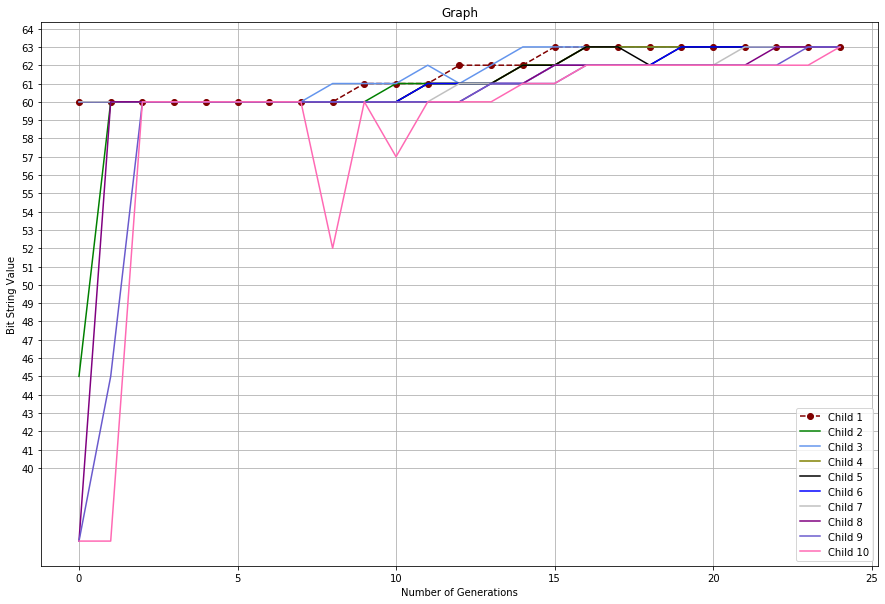

In [27]:
if __name__ == "__main__":
    parents = create_Parents(population_Size, bit_Length)
    plotting_elements = []
    
    num_of_generations = 0
    
    for _ in range(max_num_of_generations):
        children = select_Succesors(parents, population_Size)
        
        if np.random.rand() < inter_breeding_chance:
            bred_children = cross_breed(children, cross_over_type, cross_breed_shuffle, bit_cross_over, bit_Length)
            
        if np.random.rand() < mutation_chance:
            mutant_children = mutation(children, mutation_type, bit_mutation, bit_Length)
        
        survivors = evolution(parents, mutant_children, population_Size, survival_death)
        parents = survivors
        
        plotting_elements.append(survivors)
        num_of_generations = num_of_generations + 1
        
        
    plot_generation_graph(plotting_elements, num_of_generations, num_of_lines = 10, opti_fn_y = False)